In [1]:
%cd /Users/user/Desktop/IWF-DNN/data2DComplex # need cd(command)  to the directory of training dataset
%pwd
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from __future__ import print_function
import scipy.io as sio
import time
import keras
from sklearn.cross_validation import train_test_split
%matplotlib inline
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

/Users/user/Desktop/IWF-DNN/data2DComplex


Using TensorFlow backend.
/Users/user/anaconda2/envs/haha/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Import Dataset

In [2]:
DateLocation='MIMO100000_3.mat'
Data = sio.loadmat(DateLocation)#load data
Xdata=Data['X']
Ydata=Data['Y']
Xdata = np.transpose(Xdata) #transpose x(complex number in matlab format)-->10000*12
Ydata = np.transpose(Ydata) # shape 10000*12
X = np.column_stack((np.real(Xdata), np.imag(Xdata))) # change complex number to real part and imaginary part
Y = np.column_stack((np.real(Ydata), np.imag(Ydata)))
x_train, x_val ,y_train, y_val= train_test_split(X, Y, test_size=0.1) # divide data X,Y into training and validation 
DateLocation2='MIMO5000_3.mat' # import test dataset
DataTest10000 = sio.loadmat(DateLocation2)#load data
Xtest=DataTest10000['X']
Xtest = np.transpose(Xtest)
Ytest=DataTest10000['Y']
Ytest = np.transpose(Ytest)
Xtest = np.column_stack((np.real(Xtest), np.imag(Xtest)))
Ytest = np.column_stack((np.real(Ytest), np.imag(Ytest)))

In [3]:
dictData={}# set up a dictionary to store the training errors and validation errors 

In [4]:
# A funciton to plot training errors and validation errors for each epoch
# compare these errors when use different model parameters
def plot_whole(dict_data):
    fig_1 = plt.figure(figsize=(16,5))# setup a figure 
    ax_1 = fig_1.add_subplot(1,2,1)# two subplot 
    ax_2 = fig_1.add_subplot(1,2,2)
    k =int(0)
    for data in dict_data.values():# read data from dictionary which store the train and validation errors
        ax_1.plot(np.arange(0,len(data['loss'])),data['loss'], label=list(dict_data.keys())[k])
        ax_2.plot(np.arange(0,len(data['val_loss'])),data['val_loss'], label=list(dict_data.keys())[k])
        k += 1
    ax_1.legend(loc=0)
    
    ax_2.legend(loc=0)
    ax_1.set_xlabel('Epoch number')
    ax_1.set_ylabel('error(train)')
    ax_2.set_xlabel('Epoch number')
    ax_2.set_ylabel('error(valid)')
    fig_1.savefig('err.pdf')
    return fig_1, ax_1, ax_2

###  Calculate sum rate

In [5]:
import time
def obj_sum_rate(xtest, y_pred,M,N,K, samples):
    # H ： sampels*12
    sum_rate=[]
    for i in range(samples):# calculate the number of samples sum rate
        rate_nn=0 # initialize the sum rate of each sample
        H=np.reshape(xtest[i,:],[K,M,N])# reshape the 1*12 to 3*2*2
                                    # K--user number; M--the number of transmit antenna;N--the number of receive antenna
        pnn=np.reshape(y_pred[i,:],[K,M,N])      # pnn is the channel matrix 1*12 -> reshape to 3*2*2 
        for j in range(K):
            if j==0:
                rate_nn = rate_nn+np.real(np.log2( \
                                                  np.linalg.det(np.eye(N)+np.dot(np.dot(H[j,:,:].conj(),np.transpose(pnn[j,:,:])), np.transpose(H[j,:,:])))))
            # j means user0,user1,user2
            # for user0, $log(det(I+Ht* \alpha *H))$
            else:
                pnn[j,:,:]=np.transpose(pnn[j,:,:])+pnn[j-1,:,:]
                rate_nn = rate_nn+np.real(np.log2(np.linalg.det(np.eye(N)+np.dot(np.dot(H[j,:,:].conj(), pnn[j,:,:]), np.transpose(H[j,:,:]))) \
                                                  /np.linalg.det((np.eye(N)+np.dot(np.dot(H[j,:,:].conj(),pnn[j-1,:,:]),np.transpose(H[j,:,:]))))))
             # the formula of sum-rate    
        sum_rate.append(rate_nn)
    return sum_rate

### Calculate power of each sample-- whether satisfy the restrictions of original algorithm

In [6]:
def power(xtest, y_pred,M,N,K, samples):
    # H ： sampels*12
    powerall=[]
    for i in range(samples):# check each sample
        power=0
        H=np.reshape(xtest[i,:],[K,M,N])# reshape channel matrix H from 1*12 to 3*2*2
        pnn=np.reshape(y_pred[i,:],[K,M,N])  # reshape \alpha  matrix from 1*12 to 3*2*2
        for j in range(K):
            power=power+np.trace(np.transpose(pnn[j,:,:]))# calculate power: sum(trace of \alpha  matrix)
        powerall.append(np.real(power))
    return powerall

### transfer real part and imaginary part to a complex number(shape :(1,24)--->(1,12))

In [7]:
def DABtoComplex(XX, dim):
    size=XX.shape[1]
    X=np.empty( (XX.shape[0], dim), dtype= np.complex128 )
    X.real[:,:]=XX[:,0:dim]
    X.imag[:,:]=XX[:,dim:2*dim]
    return X

### plot histgram of two sum-rate distribution (DNN and IWF)

In [8]:
def histPlot(sumRate1,sumRate2, label=['DNN', 'IWF']):
#     plt.figure('%d'%K)
    plt.style.use('seaborn-deep')
    data = np.vstack([sumRate1, sumRate2]).T
    bins = np.linspace(0, max(sumRate2),50)
    plt.hist(data, bins, alpha=0.7, label=label)
#     plt.legend(loc='upper right')
    plt.xlim([0, 15])
    plt.xlabel('sum-rate')
    plt.ylabel('number of samples')
    #     plt.savefig('Histogram_%d.eps'%K, format='eps', dpi=1000)
    plt.legend()
    plt.show()
    return 0

### Plot cumulative distribution function of the sum rate of DNN and IWF

In [9]:
def CDF_Plot(sumRate1, sumRate2, label1= 'DNN', label2= 'IWF'):
    a = np.array(sumRate1) # your array of numbers
    num_bins1 = np.linspace(0, max(sumRate1), 50)
    counts1, bin_edges1 = np.histogram(a, bins='auto', normed=True)
    cdf1 = np.cumsum(counts1*np.diff(bin_edges1))

    b = np.array(sumRate2) # your array of numbers
    num_bins2 = np.linspace(0, max(sumRate2), 50)
    counts2, bin_edges2 = np.histogram(b, bins='auto', normed=True)
    cdf2 = np.cumsum(counts2*np.diff(bin_edges2))
    
    plt.xlabel('sum-rate')
    plt.plot(bin_edges1[1:], cdf1, color='black', label=label1)
    plt.plot(bin_edges2[1:],cdf2,color='red', label=label2)
    plt.legend()
    return 0


### Calculate average sum rate of DNN and IWF 

In [10]:
def performance(sumRate1,sumRate2, num):
# sumRate1, IWF; sumRate2, NN
    print('Sum-rate: IWF: %0.3f, DNN: %0.3f'%(sum(sumRate1)/num, sum(sumRate2)/num))
    print('Ratio: DNN: %0.3f%%\n' % (sum(sumRate2) / sum(sumRate1)* 100))
    return 0

### Performance comparison

In [11]:
def testPerformance(model, Xtest,x_train,x_val,y_train,y_val,Ytest,dim, M, N, K,samples):
    ypred=model.predict(Xtest)
    trainPred=model.predict(x_train)
    valPred=model.predict(x_val)
    # transfer 24 dimensions data to 12 dimension
    x=DABtoComplex(X,dim)
    xtest=DABtoComplex(Xtest,dim)
    ytest=DABtoComplex(Ytest,dim)
    ypred=DABtoComplex(ypred,dim)

    # train & val
    xtrain=DABtoComplex(x_train,dim)
    ytrain=DABtoComplex(y_train,dim)
    trainPred=DABtoComplex(trainPred,dim)
    xval=DABtoComplex(x_val,dim)
    yval=DABtoComplex(y_val,dim)
    valPred=DABtoComplex(valPred,dim)
    # draw the CDF curve of two algorithm
    # test
    nnsumRate=obj_sum_rate(xtest, ypred, M, N, K, samples)
    IWFsumRate=obj_sum_rate(xtest, ytest, M, N, K, samples)
    #trian
    nnSRTrain=obj_sum_rate(xtrain, trainPred, M, N, K, samples)
    IWFSRTrain=obj_sum_rate(xtrain, ytrain, M, N, K, samples)
    # validation
    IWFSRVal=obj_sum_rate(xval, yval, M, N, K, samples)
    nnSRVal=obj_sum_rate(xval, valPred, M, N, K, samples)

    plt.figure(1)
    plt.subplot(311)
    plt.title('CDF AnalysisTest')
    CDF_Plot(nnsumRate,IWFsumRate, 'DNNTest', 'IWFTest')
    plt.subplot(312)
    plt.title('CDF Analysis_Train')
    CDF_Plot(nnSRTrain,IWFSRTrain, 'DNNTrain', 'IWFTrain')
    plt.subplot(313)
    plt.title('CDF Analysis_val')
    CDF_Plot(nnSRVal,IWFSRVal, 'DNNVal', 'IWFVal')
    # draw histgram for two algorithm
    plt.figure(2)
    plt.subplot(211)
    plt.title('Hist AnalysisTest')
    histPlot(nnsumRate,IWFsumRate, ['DNNTest', 'IWFTest'])
    plt.subplot(212)
    plt.title('Hist Analysis_Train')
    histPlot(nnSRTrain,IWFSRTrain, ['DNNTrain', 'IWFTrain'])
    # calculate the average sum rate of two algorithm
    performance(IWFsumRate, nnsumRate, samples)
    performance(IWFSRTrain, nnSRTrain, samples)
    return 0

# Train the model

parameter:
5 hidden layers (each hidden size:480,360,240,120,60)    
input size : 24    
output size: 24   
Activate funciton: ReLu funtion f(x)=max(0,x)    
Cost function: MSE $\frac{1}{N}\sum(f(x)-t)^2$       
Optimizer: Adam optimizer (learning rate = 0.001)       
batch size: 56   
epoch: 200   

In [12]:
from keras.layers import Input, Dense
from keras.callbacks import TensorBoard
from keras.models import Model
import keras
from keras.models import Sequential
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils
from sklearn.cross_validation import train_test_split
model5layers1 = Sequential() #set up a model 
# activation=keras.layers.ReLU()
model5layers1.add(Dense(480, input_dim=24, activation='relu'))# add full connection layer( input size =24 ) 
                                                                # add activate function ReLU
model5layers1.add(Dense(360, activation='relu')) #add second full connection layer
model5layers1.add(Dense(240, activation='relu'))
model5layers1.add(Dense(120, activation='relu'))
model5layers1.add(Dense(60, activation='relu'))
model5layers1.add(Dense(24, activation='linear')) # add the output layer and the finnal activate function is linear function
model5layers1.summary() # list the structure of model 
adam=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999) # set optimizer--Adam
model5layers1.compile(loss='mse', optimizer=adam) # compile the model with loss function-->MSE and optimizer --> Adam
hist=model5layers1.fit(x_train, y_train,
                epochs=200,
                batch_size=56,  #fit the dataset, x_train and y_train, into  the above model 
                shuffle=True, # train weight and bias of the above model 
                validation_data=(x_val, y_val),callbacks=[TensorBoard(log_dir='/tmp/autoenco')])
# model.fit(x_train, y_train, epochs=100, verbose=0)
dictData['lr=0.001']=hist.history # store the training error and validation error 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 480)               12000     
_________________________________________________________________
dense_2 (Dense)              (None, 360)               173160    
_________________________________________________________________
dense_3 (Dense)              (None, 240)               86640     
_________________________________________________________________
dense_4 (Dense)              (None, 120)               28920     
_________________________________________________________________
dense_5 (Dense)              (None, 60)                7260      
_________________________________________________________________
dense_6 (Dense)              (None, 24)                1464      
Total params: 309,444
Trainable params: 309,444
Non-trainable params: 0
_________________________________________________________________
Trai

90000/90000 [==============================] - 13s 143us/step - loss: 0.0385 - val_loss: 0.1833
Epoch 66/200
90000/90000 [==============================] - 13s 142us/step - loss: 0.0389 - val_loss: 0.1763
Epoch 67/200
90000/90000 [==============================] - 13s 143us/step - loss: 0.0389 - val_loss: 0.1831
Epoch 68/200
90000/90000 [==============================] - 13s 144us/step - loss: 0.0367 - val_loss: 0.1799
Epoch 69/200
90000/90000 [==============================] - 13s 142us/step - loss: 0.0392 - val_loss: 0.1849
Epoch 70/200
90000/90000 [==============================] - 13s 142us/step - loss: 0.0388 - val_loss: 0.1690
Epoch 71/200
90000/90000 [==============================] - 13s 145us/step - loss: 0.0356 - val_loss: 0.1799
Epoch 72/200
90000/90000 [==============================] - 13s 145us/step - loss: 0.0373 - val_loss: 0.1761
Epoch 73/200
90000/90000 [==============================] - 13s 143us/step - loss: 0.0362 - val_loss: 0.1842
Epoch 74/200
90000/90000 [======

Epoch 140/200
90000/90000 [==============================] - 13s 143us/step - loss: 0.0259 - val_loss: 0.1719
Epoch 141/200
90000/90000 [==============================] - 13s 142us/step - loss: 0.0258 - val_loss: 0.1664
Epoch 142/200
90000/90000 [==============================] - 13s 141us/step - loss: 0.0246 - val_loss: 0.1784
Epoch 143/200
90000/90000 [==============================] - 13s 143us/step - loss: 0.0262 - val_loss: 0.1650
Epoch 144/200
90000/90000 [==============================] - 13s 143us/step - loss: 0.0254 - val_loss: 0.1710
Epoch 145/200
90000/90000 [==============================] - 13s 142us/step - loss: 0.0237 - val_loss: 0.1704
Epoch 146/200
90000/90000 [==============================] - 13s 142us/step - loss: 0.0270 - val_loss: 0.1640
Epoch 147/200
90000/90000 [==============================] - 13s 144us/step - loss: 0.0255 - val_loss: 0.1641
Epoch 148/200
90000/90000 [==============================] - 13s 143us/step - loss: 0.0229 - val_loss: 0.1720
Epoch 149/

### Plot the training error and validation error in the training process

(<Figure size 1152x360 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a35c40898>)

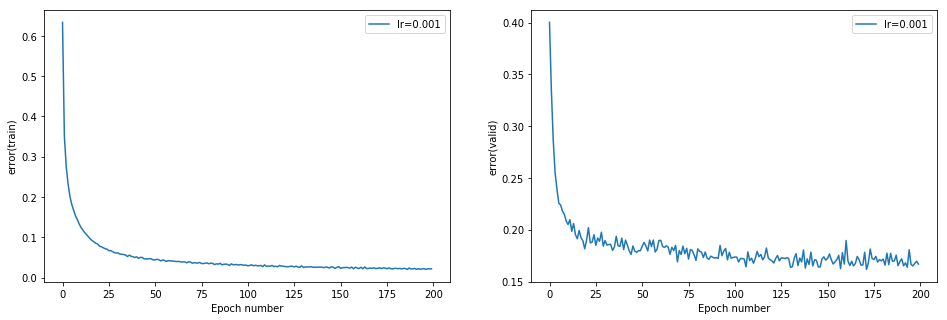

In [13]:
plot_whole(dictData)

## save the above DNN model

In [14]:
from keras.models import model_from_json
model5layers_json = model5layers1.to_json()
with open("model5layers1r001.json", "w") as json_file:
    json_file.write(model5layers_json)
# serialize weights to HDF5
model5layers1.save_weights("model5layers1r001.h5")
print("Saved model to disk")
# later...
# load json and create model
json_file = open('model5layers1r001.json', 'r')
loaded_model5layers1_json = json_file.read()
json_file.close()

loaded_model5layers1 = model_from_json(loaded_model5layers1_json)
# load weights into new model
loaded_model5layers1.load_weights("model5layers1r001.h5")
print("Loaded model from disk")

# evaluate loaded model on test data
loaded_model5layers1.compile(loss='mse', optimizer=adam)

Saved model to disk
Loaded model from disk


## save the errors data in the training process

(<Figure size 1152x360 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a2c3a93c8>)

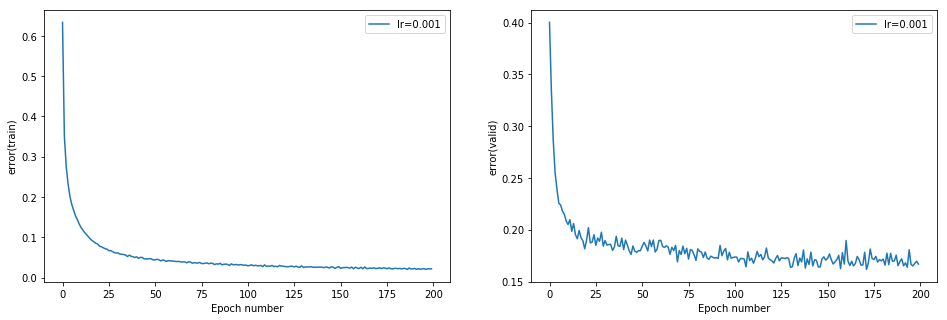

In [15]:
np.savez( "errors.npz", data=dictData )
d = np.load( "errors.npz" )
for sturctuers in sorted( d.items() ):
    val = sturctuers[1][()]
plot_whole(val)

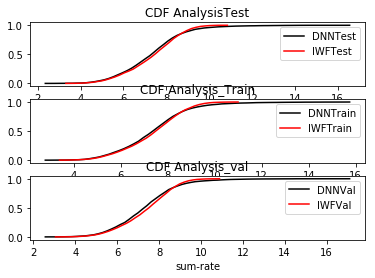

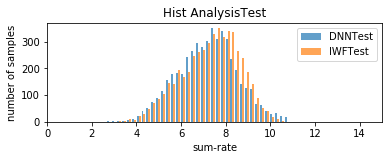

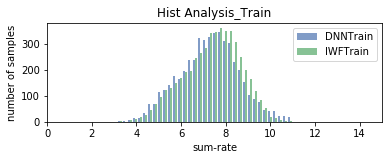

Sum-rate: IWF: 7.326, DNN: 7.301
Ratio: DNN: 99.662%

Sum-rate: IWF: 7.363, DNN: 7.372
Ratio: DNN: 100.119%



0

In [16]:
testPerformance(model5layers1, Xtest,x_train,x_val,y_train,y_val,Ytest,12, 2, 2, 3,5000)